# Load the Trained U-Net Model
# •	Make sure your model is saved and accessible. For PyTorch load it with torch.load(), and for TensorFlow/Keras use keras.models.load_model().

In [11]:
import torch
import sys
sys.path.append('/Users/vkluzner/Work/git/skeletonization')

from model.unet_att import UnetAttention

model = UnetAttention()
model = model.to('mps')
ckpt = torch.load("../output/ex2/ckpt.pth", weights_only=False)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()  # Set to evaluation mode

UnetAttention(
  (encoder): Encoder(
    (conv1): DoubleConv2d(
      (conv1): Conv2d(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2): Conv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (conv2): DoubleConv2d(
      (conv1): Conv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2): Conv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

# Prepare the Input Image
#	•	Ensure the image has the same dimensions, channels, and scaling as used during training. U-Net models usually work with 2D images with dimensions like 256x256 or 512x512 pixels.
#	•	Normalize or scale the pixel values if needed (e.g., dividing by 255 for images in the 0-255 range).

Background Label: 1
Background Mean Intensity: 0.0


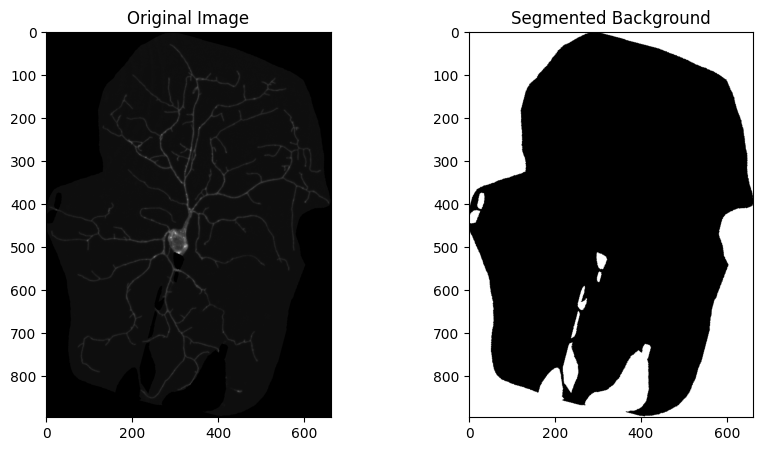

In [23]:
import cv2
import numpy as np
import math
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Load image
image_16bit = cv2.imread("../dataset/test/Real/24hrWt2_20gfp400ms_40xheadA3below_497z-MaxIP-A3-Ori.tif", cv2.IMREAD_UNCHANGED)  # or IMREAD_COLOR if 3 channels

# Step 2: Normalize to 8-bit
image = cv2.normalize(image_16bit, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
height, width = image.shape
   
# Calculate the square size of the padded image
pwr = math.ceil(max(math.log2(height), math.log2(width)))
side = 2 ** pwr

# Calculate start coordinates for the original image
start_height = math.floor((side - height) / 2)
start_width = math.floor((side - width) / 2)

# Implement Gaussian Mixture for Background Analysis:

# Step 2: Flatten the image
pixels = image.flatten().reshape(-1, 1)  # Reshape to (n_samples, 1)

# Step 3: Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pixels)

# Step 4: Analyze GMM components
labels = gmm.predict(pixels)  # Labels for each pixel
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()

# Identify background component (typically the one with the lowest mean intensity)
background_label = np.argmin(means)
print("Background Label:", background_label)
print("Background Mean Intensity:", means[background_label])

# Step 5: Reshape the labels to the original image shape
segmented_image = labels.reshape(image.shape)

# Visualize the segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Segmented Background")
plt.imshow(segmented_image == background_label, cmap='gray')  # Highlight background
plt.show()

# Create a new array with padding, initialized with background as Gaussian variable
# padded_image = np.zeros((side, side), dtype=image.dtype)
# padded_image[0:side, 0:start_width] = padding_gray_level
# padded_image[0:side, start_width+width:side] = padding_gray_level
# padded_image[0:start_height, start_width:start_width+width] = padding_gray_level
# padded_image[start_height+height:side, start_width:start_width+width] = padding_gray_level

# Step 3: Generate Gaussian-distributed pixel values
# Use np.random.normal to generate values for each pixel in the image
padded_image = np.random.normal(loc=means[background_label], scale=np.sqrt(variances[background_label]), size=(side, side))

# Step 4: Clip the values to the valid pixel range [0, 255] for an 8-bit grayscale image
padded_image = np.clip(padded_image, 0, 255)

# Step 5: Convert to integer values (uint8)
padded_image = padded_image.astype(np.uint8)

padded_image[start_height:start_height+height, start_width:start_width+width] = image
cv2.imwrite("orig.png", padded_image)

padded_image = padded_image / 255.
image_flip_0 = cv2.flip(padded_image, 0)
image_flip_1 = cv2.flip(padded_image, 1)
image_flip__1 = cv2.flip(padded_image, -1)
image = np.stack([padded_image, image_flip_0, image_flip_1, image_flip__1])

In [ ]:
import cv2
import numpy as np

# Load image
image = cv2.imread("../dataset/test/Realistic-SBR-1-Sample-1-time-36.00.pgm", cv2.IMREAD_UNCHANGED)  # or IMREAD_COLOR if 3 channels
height, width = image.shape
# Create a new array with padding, initialized to black (0)
template_image = np.zeros((height+24, width+24), dtype=image.dtype)
template_image[0:12, 12:12+width] = image[0:12, 0:width]
template_image[height+12:height+24, 12:12+width] = image[height-12:height, 0:width]
template_image[12:12+height, 0:12] = image[0:height, 0:12]
template_image[12:12+height, width+12:width+24] = image[0:height, width-12:width]
template_image[0:12, 0:12] = image[height-12:height, width-12:width]
template_image[0:12, width+12:width+24] = image[height-12:height, 0:12]
template_image[height+12:height+24, 0:12] = image[0:12, width-12:width]
template_image[height+12:height+24, width+12:width+24] = image[0:12, 0:12]
padded_image = template_image
padded_image[12:12+height, 12:12+width] = image
cv2.imwrite("orig.png", padded_image)

padded_image = padded_image / 255.
image_flip_0 = cv2.flip(padded_image, 0)
image_flip_1 = cv2.flip(padded_image, 1)
image_flip__1 = cv2.flip(padded_image, -1)
image = np.stack([padded_image, image_flip_0, image_flip_1, image_flip__1])

# Run the Inference
#	•	Pass the prepared image through the U-Net model to obtain the predicted segmentation mask.

In [15]:
# PyTorch example
with torch.no_grad():  # Disable gradient calculation
    input_tensor = torch.tensor(image).unsqueeze(1).to(torch.float32).to('mps')
    pred, _, _, _ = model(input_tensor)
    pred = torch.sigmoid(pred)
    pred_ori, pred_flip_0, pred_flip_1, pred_flip__1 = pred
    pred_ori = pred_ori.cpu().numpy()
    pred_flip_0 = cv2.flip(pred_flip_0.cpu().numpy(), 0)
    pred_flip_1 = cv2.flip(pred_flip_1.cpu().numpy(), 1)
    pred_flip__1 = cv2.flip(pred_flip__1.cpu().numpy(), -1)
    pred = np.mean([pred_ori, pred_flip_0, pred_flip_1, pred_flip__1], axis=0)
    pred = pred[start_height:start_height+height, start_width:start_width+width]

# Post-process the Output
#	•	U-Net models often output probabilities (values between 0 and 1), so you may want to apply a threshold to convert it to binary.

In [ ]:
threshold = 0.74
binary_mask = (pred > threshold).astype(np.uint8) * 255  # Convert to 0 and 255 for binary mask
# Save the mask
cv2.imwrite("predicted_mask2.png", binary_mask)

True

# Display or Save the Inference Result
#	•	You can save or display the binary mask as needed.

In [ ]:
cv2.imshow('Output Window', binary_mask)
# Wait for a key press indefinitely or for a specific amount of time
cv2.waitKey(0)  # Waits indefinitely; use cv2.waitKey(1000) to wait 1 second
# Destroy all OpenCV windows
cv2.destroyAllWindows()